LOF结合普通的BN：直接使用LofWithBN中生成的数据作为输入
===

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
# from Plot_XZ import *
# from PCA import *

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.style.use('default')
font1 ={'family': 'times new roman', 'weight':'light', 'size': 12}  
# font2 ={'family': 'Arial', 'weight':'normal', 'size': 12}  
def Plot_XZ(elec_year, elec_faults, Savefig):
# 画出原始图
    Company_names = ['Xizang', 'Xinjiang', 'Heilongjiang']
    k = np.array([0, 41, 83])
    j= 0
    # j, k1 = 0, 6
    plt.figure(figsize=(4, 3), facecolor='w')

    ax = plt.subplot(1, 1, 1)
    for jx in range(7):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016', '2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\LOFG_BN\\Picture\\1.svg', format='svg')
    plt.show()
    plt.figure(figsize=(4, 3), facecolor='w')

    ax = plt.subplot(1, 1, 1)
    for jx in range(7, 18, 1):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[1]], loc='upper left', frameon=False, fontsize='small')
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\LOFG_BN\\Picture\\2.svg', format='svg')
    plt.show()
    
    plt.figure(figsize=(4, 3), facecolor='w')
    ax = plt.subplot(1, 1, 1)
    for jx in range(18, 25, 1):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[2]], loc='upper left', frameon=False, fontsize='small')
#     leg = plt.legend()
#     leg.get_frame().set_linewidth(0.0)
    
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\LOFG_BN\\Picture\\3.svg', format='svg')
    plt.show()
    return 0

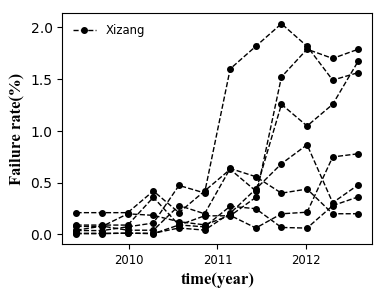

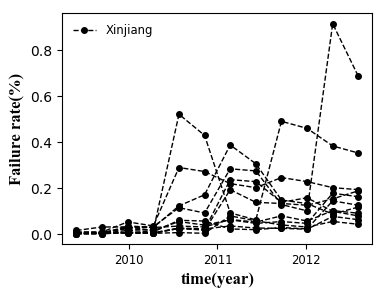

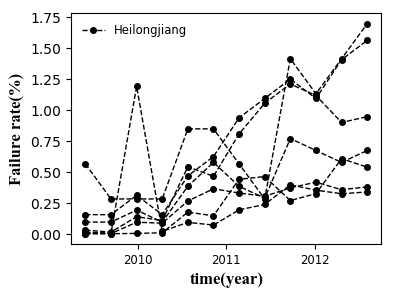

In [3]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储

elec_data = pd.read_csv('XZnozero_12.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values

# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 1, size=[len(elec_data.Year.values), 4])
SNR_Tem = np.random.normal(0, 1, size=[len(elec_data.Year.values), 1])
# #特征因素分析

elec_tem = elec_data.Tem.values + SNR_Tem[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)


# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
Norm_year_Mean = np.mean(elec_year)
Norm_year_std = np.std(elec_year)
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
data_cs_year = elec_year
# data_cs_year[42:45] = 12
# print(elec_year1)

elec_data.Fault.values[202] =200
elec_data.Fault.values[203] =150
elec_data.Fault.values[218] =165
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)

# print(elec_faults)
# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*12:(i+1)*12] for i in np.arange(25)])
elec_year2 = np.array([elec_year1[i*12:(i+1)*12] for i in np.arange(25)])
elec_char1 = np.array([elec_tem1[i*12:(i+1)*12] for i in np.arange(25)])
elec_char2 = np.array([elec_hPa1[i*12:(i+1)*12] for i in np.arange(25)])
companyABC2 = np.array([companyABC[i*12:(i+1)*12] for i in np.arange(25)])

# 共享变量设置
xs_char1 = shared(np.asarray(elec_tem1))
xs_char2 = shared(np.asarray(elec_hPa1))
xs_char3 = shared(np.asarray(elec_RH1))

ys_faults = shared(np.asarray(elec_faults))
xs_year = shared(np.asarray(elec_year1))
Num_shared = shared(np.asarray(companyABC))
# print(companyABC)
# print(companiesABC)
# print(len(data_cs_year))
# print(len(elec_faults))
# 画图
Plot_XZ(elec_year2, elec_faults2, Savefig)


def logit(x):
    return 1/(1+np.exp(-x))
def tlogit(x):
    return 1/(1+tt.exp(-x))
def Phi(x):
    # probit transform
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))

In [4]:
# 相关系数计算,应用公式0.5*value+0.5可以将相关系数矩阵的值域由[-1,1]映射为[0,1]
All_data = np.vstack((elec_faults1,elec_year1, elec_tem1, elec_hPa1, elec_RH1)).T
# print(All_data)
Cor_all = np.corrcoef(All_data, rowvar=0)
Cor_all = 0.5*Cor_all+0.5
# print(Cor_all)
# for i in np.arange(len(Cor_all)):
#     print(Cor_all[0][i])
#     print(Cor_all[1][i])
#     print(Cor_all[2][i])
#     print(Cor_all[3][i])
#     print(Cor_all[4][i])
Weight = np.array([1.0, 0.7311650684715499, 0.4273930180878881 ,0.35659903015510097 ,0.6406373000946504])
Weight_sqrt = np.sqrt(Weight) #取平方根作为LOF权重
for i in range(5):
    print(Weight_sqrt[i])

1.0
0.8550819074635774
0.6537530252992242
0.5971591330249425
0.8003982134504364


In [5]:
# 建模，模型
with pm.Model() as model_1:
    # define priors
    alpha = pm.HalfCauchy('alpha', 10, testval=.6)
    
    a0 = pm.Normal('a0', 0., 1.)
    σ_a = pm.HalfCauchy('σ_a', 2.)
    Δ_a = pm.Normal('Δ_a', 0., 20., shape=companiesABC)


    theta5 = pm.Normal('theta5', 0, 10)  
    mu_5 = pm.Normal('mu_5', mu=theta5, tau=0.001)
    sd_5 = pm.HalfCauchy('sd_5', 10)

    theta4 = pm.Normal('theta4', 0, 10)  
    mu_4 = pm.Normal('mu_4', mu=theta4, tau=0.001)
    sd_4 = pm.HalfCauchy('sd_4', 10)
    
    theta3 = pm.Normal('theta3', 0, 10)
    mu_3 = pm.Normal('mu_3', mu=theta3, tau=0.001)
    sd_3 = pm.HalfCauchy('sd_3', 10)
    
    theta2 = pm.Normal('theta2', 0, 10)
    mu_2 = pm.Normal('mu_2', mu=theta2, tau=0.001)
    sd_2 = pm.HalfCauchy('sd_2', 10)
    
#     mu1_sd = pm.Uniform('mu1_sd', lower=0.001, upper=10)
    theta1 = pm.Deterministic('theta1', a0 + (σ_a*Δ_a).cumsum())
#     mu_1 = pm.Normal('mu_1', mu=theta1, tau=mu1_sd, shape=companiesABC)
#     mu_1 = pm.Normal('mu_1', mu=0, tau=0.001, shape=companiesABC)
#     sd_1 = pm.HalfCauchy('sd_1', 10)

    beta5 = pm.Normal('beta5', mu_5, sd_5, shape=companiesABC)  
    beta4 = pm.Normal('beta4', mu_4, sd_4, shape=companiesABC) 
    beta3 = pm.Normal('beta3', mu_3, sd_3, shape=companiesABC)
    beta2 = pm.Normal('beta2', mu_2, sd_2, shape=companiesABC)
#     beta1 = pm.Normal('beta1', mu_1, sd_1, shape=companiesABC)
    beta_sd = pm.HalfCauchy('beta_sd', 20)
    beta = pm.Normal('beta', 0, beta_sd)
    
#     up_u = pm.HalfCauchy('up_u', 10)
#     u = pm.Uniform('u',lower=0.001, upper=5) 
#                             u*( tt.sqrt(theta1[Num_shared]**2) + tt.sqrt(beta2[Num_shared]**2)+ tt.sqrt(beta5[Num_shared]**2))
    beta_mu = pm.Deterministic('beta_mu', 
                               tt.exp(beta +  \
                                            (theta1[Num_shared] * xs_year + beta2[Num_shared] * xs_char1 +\
                                             beta3[Num_shared] * xs_char2 + beta4[Num_shared] * xs_char3 + beta5[Num_shared] * xs_year**2)) )

    Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_mu, observed=ys_faults)  # 观测值
    trace_1 = pm.sample(2000,  init='advi+adapt_diag' )

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = -161.08:  17%|████████▌                                         | 34251/200000 [00:44<03:37, 762.93it/s]
Convergence archived at 34300
Interrupted at 34,299 [17%]: Average Loss = 8.2744e+22
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:20<00:00, 17.84it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 195 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



            mean        sd  mc_error    hpd_2.5   hpd_97.5
sd_2    0.826146  1.449711  0.061602   0.019120   3.101966
mu_2   -0.012797  0.708471  0.029474  -1.458063   1.508270
theta2  0.073431  9.884444  0.282609 -20.417221  18.122952
sd_3    4.403492  5.520444  0.269095   0.100127  13.178016
mu_3   -1.251389  3.328347  0.165935  -8.198622   6.255458
theta3  0.519324  9.998742  0.360452 -19.508191  17.900801
sd_4    0.928332  2.375093  0.153910   0.019362   3.454807
mu_4    0.112324  1.508847  0.110132  -1.147126   1.978097
theta4  0.460440  9.372936  0.261383 -18.535999  17.623861


D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=-464.92261224707045, WAIC_se=60.515352191159856, p_WAIC=16.57328051707276)


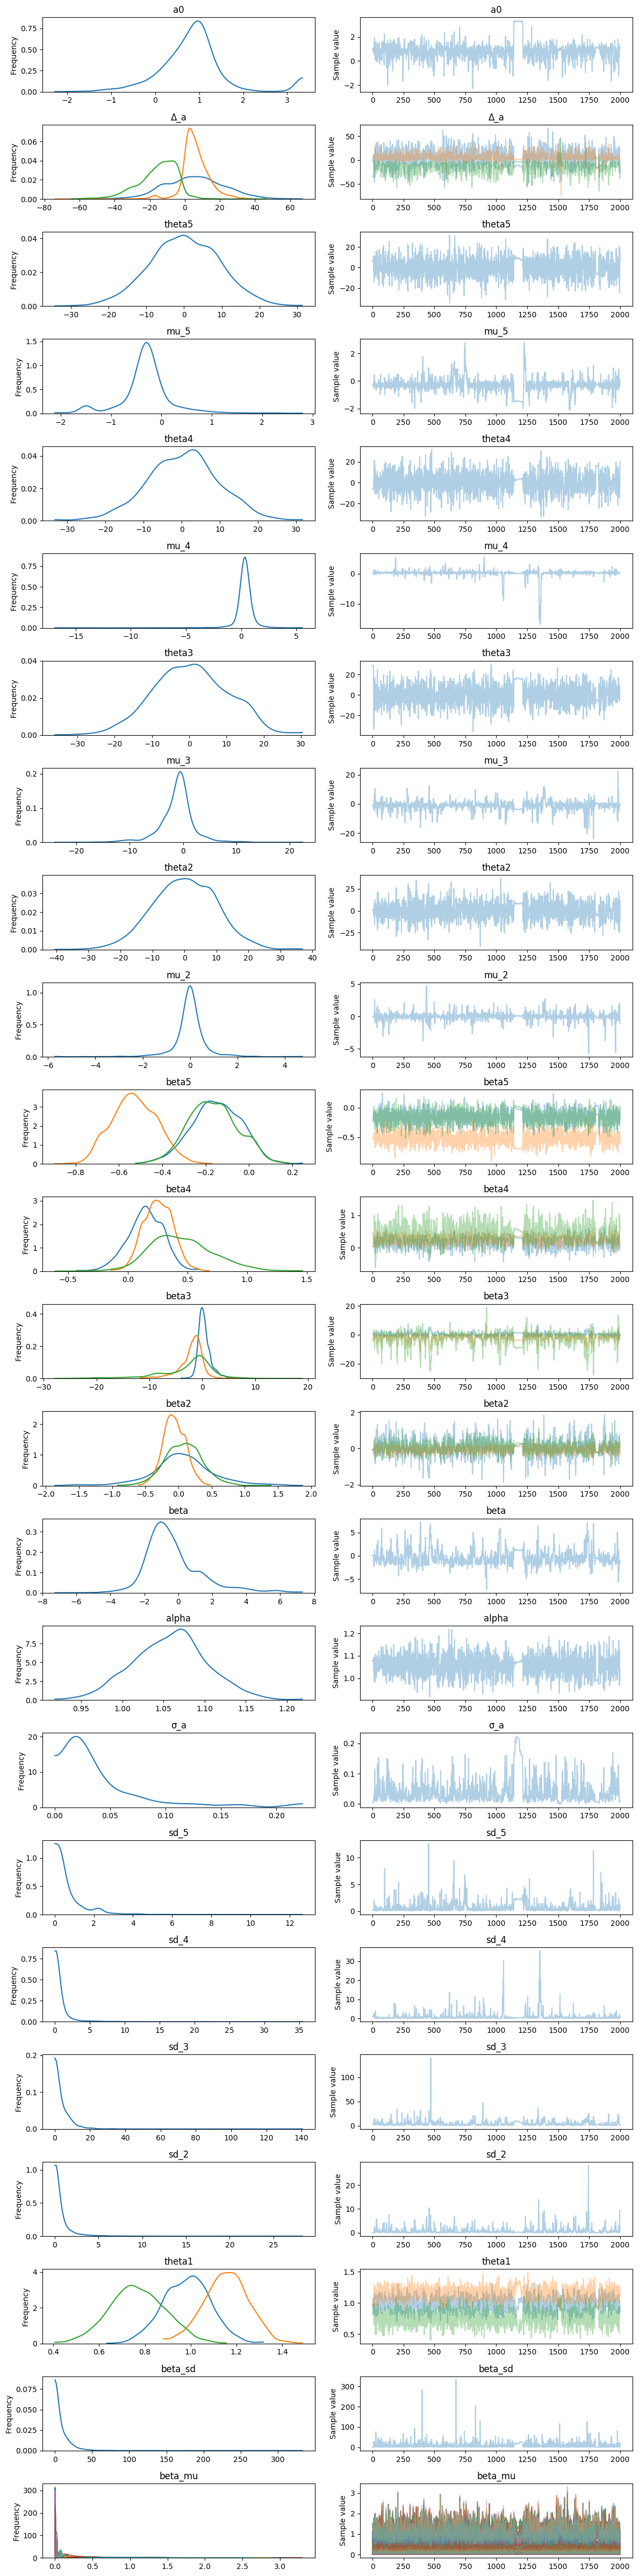

In [6]:
varnames1 = ['sd_2', 'mu_2', 'theta2', 'sd_3', 'mu_3', 'theta3', 'sd_4', 'mu_4', 'theta4']
tmp_mu1 = pm.df_summary(trace_1, varnames1)
print(tmp_mu1)



WAIC_1 = pm.waic(trace_1, model_1)
print(WAIC_1)
chain_1 = trace_1[1000:]
pm.traceplot(trace_1)
plt.show()

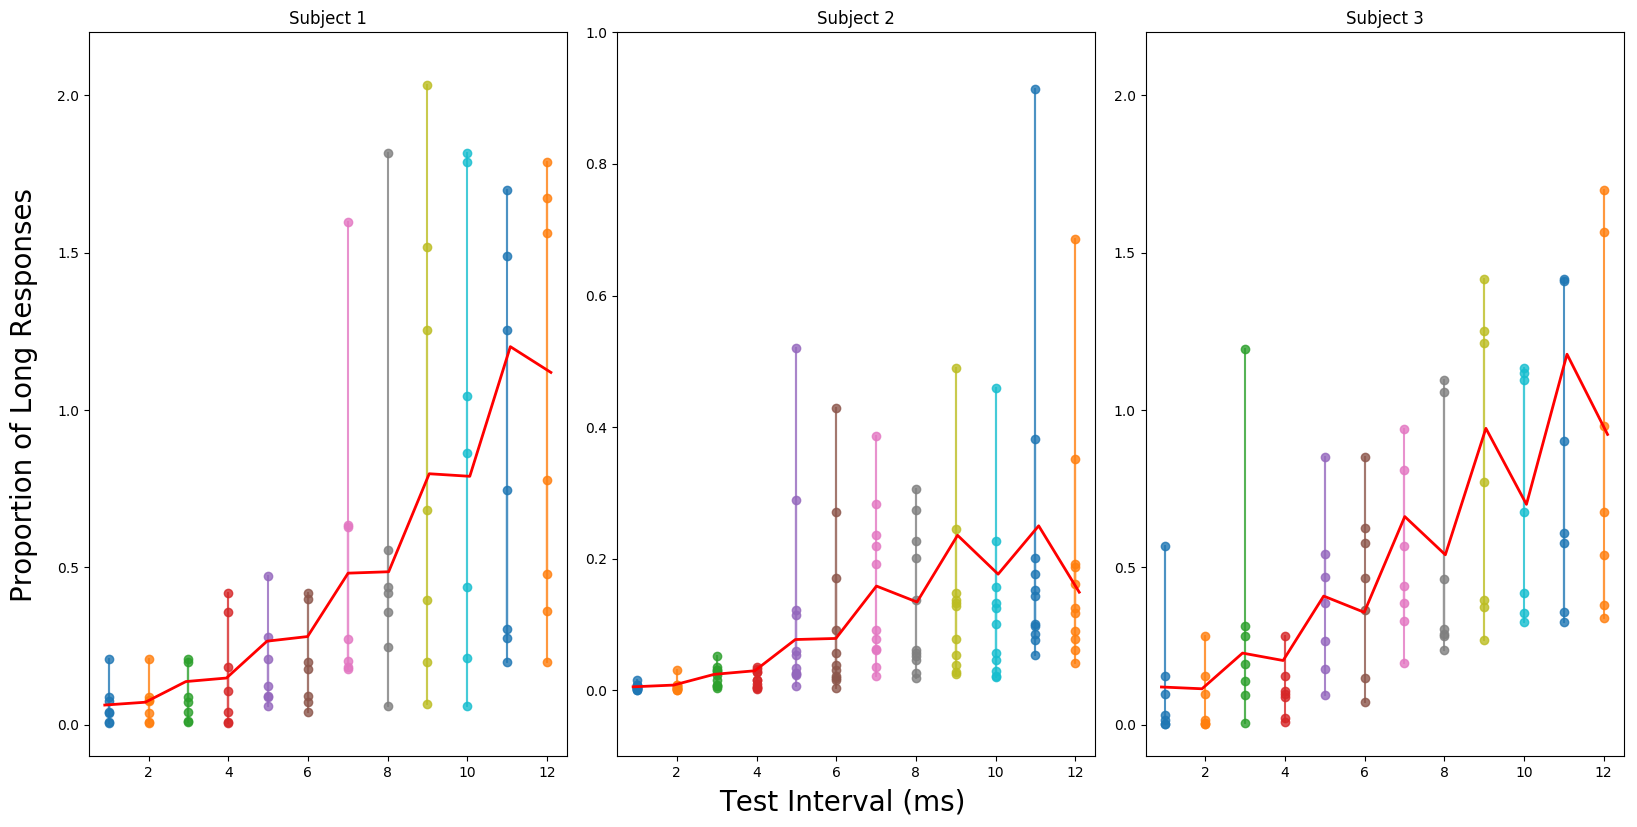

In [7]:
varnames1 = ['beta_mu']
tmp_mu1 = pm.df_summary(chain_1, varnames1)
Beta_Mu1 = tmp_mu1['mean']

Beta_Mu_1 = np.array([Beta_Mu1[i*12:(i+1)*12] for i in np.arange(25)])


fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(1, 3)
ppcsamples = 100


for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip*7:(ip+1)*7, :]*Norm_year_std + Norm_year_Mean
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    
    y2 = Beta_Mu_1[ip*7:(ip+1)*7, :]
    if ip==1:
        xp = elec_year2[ip*7:((ip+1)*7+4), :]*Norm_year_std + Norm_year_Mean
        yp = elec_faults2[ip*7:((ip+1)*7+4), :]
        y2 = Beta_Mu_1[ip*7:((ip+1)*7+4), :]
    if ip==2:
        xp = elec_year2[18:25, :]*Norm_year_std + Norm_year_Mean
        yp = elec_faults2[18:25, :]
        y2 = Beta_Mu_1[18:25, :]
    xl = np.linspace(0.9, 12.1, 12)

    
    y2 = y2.mean(axis=0)
#     print(y2)
    ax.plot(xp, yp, marker='o', alpha=.8)
    plt.plot(xl, y2,  'r', linewidth=2)
    plt.axis([0.5, 12.5, -.1, 2.2])
    if ip==1:
        plt.axis([0.5, 12.5, -.1, 1.0])
    plt.title('Subject %s' % (ip + 1))

plt.tight_layout()
plt.show()

In [8]:
# 读取LOF权重处理之后的数据
Weight_Fault_ABC_All = np.loadtxt('Weight_Fault_ABC_All.csv',delimiter = ',')
Weight_Fault_ABC_All2 = np.array([Weight_Fault_ABC_All[i*12:(i+1)*12] for i in np.arange(25)])
ys_faults_Model2 = shared(np.asarray(Weight_Fault_ABC_All))

In [9]:
# 建模，模型
with pm.Model() as model_2:
    # define priors
    alpha = pm.HalfCauchy('alpha', 10, testval=.6)
    
    a0 = pm.Normal('a0', 0., 1.)
    σ_a = pm.HalfCauchy('σ_a', 2.)
    Δ_a = pm.Normal('Δ_a', 0., 20., shape=companiesABC)


    theta5 = pm.Normal('theta5', 0, 10)  
    mu_5 = pm.Normal('mu_5', mu=theta5, tau=0.001)
    sd_5 = pm.HalfCauchy('sd_5', 10)

    
    
    theta4 = pm.Normal('theta4', -1, 10)  
    mu_4 = pm.Normal('mu_4', mu=theta4, tau=0.1)
    sd_4 = pm.HalfCauchy('sd_4', 3)
    
    theta3 = pm.Normal('theta3', -2, 10)
    mu_3 = pm.Normal('mu_3', mu=theta3, tau=0.1)
    sd_3 = pm.HalfCauchy('sd_3', 8)
    
    theta2 = pm.Normal('theta2', -1, 5)
    mu_2 = pm.Normal('mu_2', mu=theta2, tau=0.1)
    sd_2 = pm.HalfCauchy('sd_2', 3)
#     theta4 = pm.Normal('theta4', 0, 10)  
#     mu_4 = pm.Normal('mu_4', mu=theta4, tau=0.001)
#     sd_4 = pm.HalfCauchy('sd_4', 10)
    
#     theta3 = pm.Normal('theta3', 0, 10)
#     mu_3 = pm.Normal('mu_3', mu=theta3, tau=0.001)
#     sd_3 = pm.HalfCauchy('sd_3', 10)
    
#     theta2 = pm.Normal('theta2', 0, 10)
#     mu_2 = pm.Normal('mu_2', mu=theta2, tau=0.001)
#     sd_2 = pm.HalfCauchy('sd_2', 10)
    
#     mu1_sd = pm.Uniform('mu1_sd', lower=0.001, upper=10)
    theta1 = pm.Deterministic('theta1', a0 + (σ_a*Δ_a).cumsum())
#     mu_1 = pm.Normal('mu_1', mu=theta1, tau=mu1_sd, shape=companiesABC)
#     mu_1 = pm.Normal('mu_1', mu=0, tau=0.001, shape=companiesABC)
#     sd_1 = pm.HalfCauchy('sd_1', 10)

    beta5 = pm.Normal('beta5', mu_5, sd_5, shape=companiesABC)  
    beta4 = pm.Normal('beta4', mu_4, sd_4, shape=companiesABC) 
    beta3 = pm.Normal('beta3', mu_3, sd_3, shape=companiesABC)
    beta2 = pm.Normal('beta2', mu_2, sd_2, shape=companiesABC)
#     beta1 = pm.Normal('beta1', mu_1, sd_1, shape=companiesABC)
    beta_sd = pm.HalfCauchy('beta_sd', 20)
    beta = pm.Normal('beta', 0, beta_sd)
    
#     up_u = pm.HalfCauchy('up_u', 10)
    u = pm.Uniform('u',lower=0.001, upper=5) 

    beta_mu2 = pm.Deterministic('beta_mu2', 
                               tt.exp(beta + \
                            u*( tt.sqrt(theta1[Num_shared]**2) + tt.sqrt(beta2[Num_shared]**2)+ tt.sqrt(beta5[Num_shared]**2))  + \
                                            (theta1[Num_shared] * xs_year + beta2[Num_shared] * xs_char1 +\
                                             beta3[Num_shared] * xs_char2 + beta4[Num_shared] * xs_char3 + beta5[Num_shared] * xs_year**2)) )

    Observed2 = pm.Weibull("Observed2", alpha=alpha, beta=beta_mu2, observed=ys_faults_Model2)  # 观测值
    trace_2 = pm.sample(2000,  init='advi+adapt_diag' )

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = -178.76:  15%|███████▋                                          | 30869/200000 [00:44<04:02, 698.69it/s]
Convergence archived at 30900
Interrupted at 30,899 [15%]: Average Loss = 3.4197e+10
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [05:03<00:00,  8.23it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 154 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=-497.10447908131897, WAIC_se=57.5105154589501, p_WAIC=15.322449037770614)


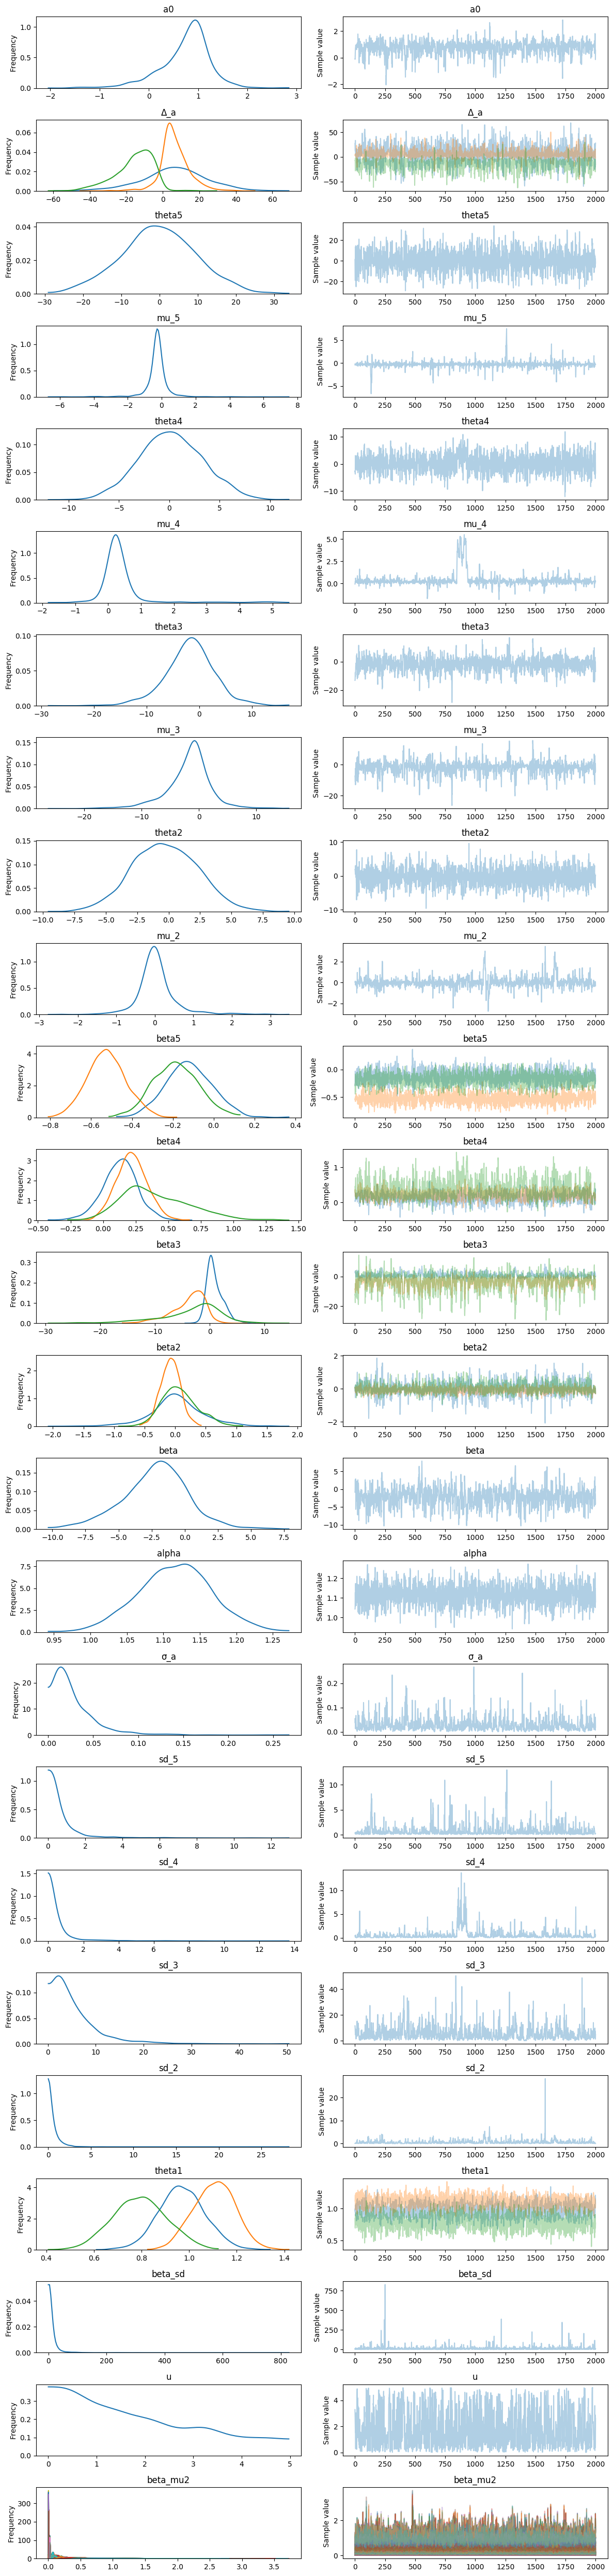

In [10]:
WAIC_2 = pm.waic(trace_2, model_2)
print(WAIC_2)
chain_2 = trace_2[1000:]
pm.traceplot(trace_2)
plt.show()

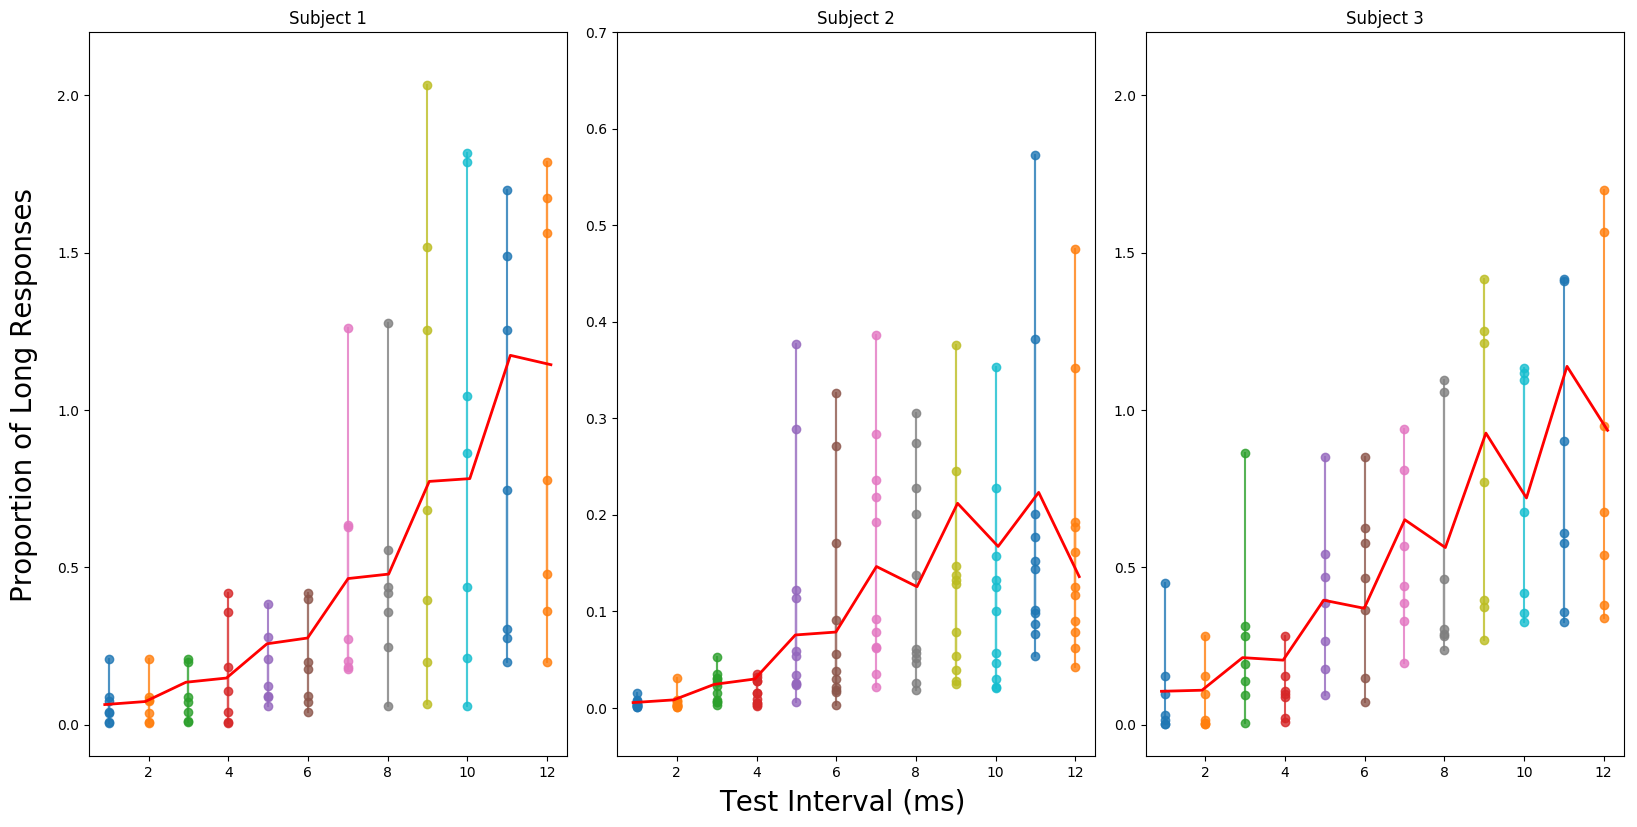

In [11]:
varnames2 = ['beta_mu2']
tmp_mu2 = pm.df_summary(chain_2, varnames2)
Beta_Mu2 = tmp_mu2['mean']

Beta_Mu_2 = np.array([Beta_Mu2[i*12:(i+1)*12] for i in np.arange(25)])


fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(1, 3)
ppcsamples = 100


for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip*7:(ip+1)*7, :]*Norm_year_std + Norm_year_Mean
    yp = Weight_Fault_ABC_All2[ip*7:(ip+1)*7, :]
    
    y2 = Beta_Mu_2[ip*7:(ip+1)*7, :]
    if ip==1:
        xp = elec_year2[ip*7:((ip+1)*7+4), :]*Norm_year_std + Norm_year_Mean
        yp = Weight_Fault_ABC_All2[ip*7:((ip+1)*7+4), :]
        y2 = Beta_Mu_2[ip*7:((ip+1)*7+4), :]
    if ip==2:
        xp = elec_year2[18:25, :]*Norm_year_std + Norm_year_Mean
        yp = Weight_Fault_ABC_All2[18:25, :]
        y2 = Beta_Mu_2[18:25, :]
    xl = np.linspace(0.9, 12.1, 12)

    
    y2 = y2.mean(axis=0)
#     print(y2)
    ax.plot(xp, yp, marker='o', alpha=.8)
    plt.plot(xl, y2,  'r', linewidth=2)
    plt.axis([0.5, 12.5, -.1, 2.2])
    if ip==1:
        plt.axis([0.5, 12.5, -.05, 0.7])
    plt.title('Subject %s' % (ip + 1))

plt.tight_layout()
plt.show()

In [12]:
WAIC_2 = pm.compare([trace_1, trace_2], [model_1, model_2], ic='WAIC')
print(WAIC_2)

     WAIC  pWAIC  dWAIC weight     SE   dSE warning
1  -497.1  15.32      0      1  57.51     0       1
0 -464.92  16.57  32.18      0  60.52  8.03       1


In [13]:
# 计算拟合的均方误差
from sklearn.metrics import mean_absolute_error
def Rmse(predictions, targets):
    return  np.sqrt(np.mean((predictions - targets)**2))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

varnames1 = ['beta_mu']
varnames2 = ['beta_mu2']

tmp_mu1 = pm.df_summary(trace_1, varnames1)
tmp_mu2 = pm.df_summary(chain_2, varnames2)

Beta_Mu1 = tmp_mu1['mean']
Beta_Mu2 = tmp_mu2['mean']

ALL_faults3 = (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
Beta_Mu1 = Beta_Mu1/100 #还原
Beta_Mu2 = Beta_Mu2/100 #还原
ALL_faults1 = Weight_Fault_ABC_All/100

rmse2 = {}
rmse1 = {}
index = [0, 84, 216, 300]
MAE1 = {}; MAE2 = {}
MAPE1 = {}; MAPE2 = {}
for ip in np.arange(3):
    rmse1[ip] = Rmse(Beta_Mu1[index[ip]:index[ip+1]], ALL_faults3[index[ip]:index[ip+1]])
    rmse2[ip] = Rmse(Beta_Mu2[index[ip]:index[ip+1]], ALL_faults1[index[ip]:index[ip+1]])
#     MAE
    MAE1[ip] = mean_absolute_error(Beta_Mu1[index[ip]:index[ip+1]], ALL_faults3[index[ip]:index[ip+1]])
    MAE2[ip] = mean_absolute_error(Beta_Mu2[index[ip]:index[ip+1]], ALL_faults1[index[ip]:index[ip+1]])
#     MAPE    
    MAPE1[ip] = mean_absolute_percentage_error(Beta_Mu1[index[ip]:index[ip+1]], ALL_faults3[index[ip]:index[ip+1]])
    MAPE2[ip] = mean_absolute_percentage_error(Beta_Mu2[index[ip]:index[ip+1]], ALL_faults1[index[ip]:index[ip+1]])
print('对比拟合误差rmse1:', rmse1)
print('用于本文模型rmse2:', rmse2)
print('对比拟合误差MAE1:', MAE1)
print('用于本文模型MAE2:', MAE2)
print('对比拟合误差MAPE1:', MAPE1)
print('用于本文模型MAPE2:', MAPE2)

对比拟合误差rmse1: {0: 0.004460610360194829, 1: 0.001294958452854503, 2: 0.0035069054382768647}
用于本文模型rmse2: {0: 0.004216493616105588, 1: 0.001007771814270587, 2: 0.0033715553084765837}
对比拟合误差MAE1: {0: 0.003074964148627559, 1: 0.0008113903521862608, 2: 0.002756540454721951}
用于本文模型MAE2: {0: 0.0029418517745272758, 1: 0.0006980088511706823, 2: 0.002690702036572747}
对比拟合误差MAPE1: {0: 66.35080234279273, 1: 73.57838056924935, 2: 61.78270384438369}
用于本文模型MAPE2: {0: 64.12438557996987, 1: 69.3897353028372, 2: 59.8672184029595}


In [14]:
# 计算置信区间大小
def MPIWidth(y_5, y_95): 
    y_5, y_95 = np.array(y_5), np.array(y_95)
    return np.mean(np.abs((y_5 - y_95))) * 100

# 后验。用于预测，计算预测误差
data_cs = pd.read_csv('XZnozero_12_Pred.csv')
data_cs_1 = data_cs.Year.values # 测试数据时间
data_cs_1 = (data_cs_1 - np.mean(data_cs_1)) / np.std(data_cs_1)

xs_year.set_value(np.asarray(data_cs_1))
with model_1:
    pp_trace1 = pm.sample_ppc(trace_1, 1000)
post_pred1 = pp_trace1['Observed']
yipred_mean1 = post_pred1.mean(axis=0)
sig_Model1 = pm.hpd(post_pred1, alpha=0.05)
sig_Model1 = np.array(sig_Model1)

with model_2:
    pp_trace2 = pm.sample_ppc(trace_2, 1000)
post_pred2 = pp_trace2['Observed2']
yipred_mean2 = post_pred2.mean(axis=0)
sig_Model2 = pm.hpd(post_pred2, alpha=0.05)
sig_Model2 = np.array(sig_Model2)


Pred_MAP2 = yipred_mean2/100 #还原
Pred_MAP1 = yipred_mean1/100 #还原
# print(sig_Model2[:, 0])
# print(len(Pred_MAP1))

Pred_fault = data_cs.Fault.values / data_cs.Nums.values #这里不需要除以100
Pred_fault_A = Pred_fault[:12]  #预测值,只预测一年的值
Pred_fault_B = Pred_fault[84:96]
Pred_fault_C = Pred_fault[216:228]
Pred_fault_ABC = np.vstack((Pred_fault_A, Pred_fault_B, Pred_fault_C))
# print(Pred_fault_ABC)
ALL_faults1 = Weight_Fault_ABC_All/100

rmse2 = {}
rmse1 = {}
index = [0, 84, 216, 300]
MAE1 = {}; MAE2 = {}
MAPE1 = {}; MAPE2 = {}
MPIW1 = {}; MPIW2 = {}
for ip in np.arange(3):
    rmse1[ip] = Rmse(Pred_MAP1[index[ip]:(index[ip]+12)], Pred_fault_ABC[ip])
    rmse2[ip] = Rmse(Pred_MAP2[index[ip]:(index[ip]+12)], ALL_faults1[index[ip]:(index[ip]+12)])  
#     MAE
    MAE1[ip] = mean_absolute_error(Pred_MAP1[index[ip]:(index[ip]+12)], Pred_fault_ABC[ip])
    MAE2[ip] = mean_absolute_error(Pred_MAP2[index[ip]:(index[ip]+12)], ALL_faults1[index[ip]:(index[ip]+12)])
#     MAPE    
    MAPE1[ip] = mean_absolute_percentage_error(Pred_MAP1[index[ip]:(index[ip]+12)], Pred_fault_ABC[ip])
    MAPE2[ip] = mean_absolute_percentage_error(Pred_MAP2[index[ip]:(index[ip]+12)], ALL_faults1[index[ip]:(index[ip]+12)])
#     MPIW    
    MPIW1[ip] = MPIWidth(sig_Model1[index[ip]:index[ip+1],0], sig_Model1[index[ip]:index[ip+1],1])
    MPIW2[ip] = MPIWidth(sig_Model2[index[ip]:index[ip+1],0], sig_Model2[index[ip]:index[ip+1],1])
print('对比预测误差rmse1:', rmse1)
print('用于本文模型rmse2:', rmse2)
print('对比预测误差MAE1:', MAE1)
print('用于本文模型MAE2:', MAE2)
print('对比预测误差MAPE1:', MAPE1)
print('用于本文模型MAPE2:', MAPE2)
print('对比预测误差MPIW1:', MPIW1)
print('用于本文模型MPIW2:', MPIW2)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2462.60it/s]


对比预测误差rmse1: {0: 0.0034719437672300862, 1: 0.000858903033548521, 2: 0.004049576260885311}
用于本文模型rmse2: {0: 0.0032854284537145394, 1: 0.000720837116860857, 2: 0.004306155204026853}
对比预测误差MAE1: {0: 0.0023520534249091003, 1: 0.0006559581839446415, 2: 0.0035059552767334225}
用于本文模型MAE2: {0: 0.0022092161241495877, 1: 0.0005560493949141367, 2: 0.0037433856031091673}
对比预测误差MAPE1: {0: 60.98608667125237, 1: 55.56536841981311, 2: 73.82672328746622}
用于本文模型MAPE2: {0: 60.06486133444346, 1: 53.02801092575271, 2: 92.74766668750004}
对比预测误差MPIW1: {0: 142.70337044305157, 1: 32.22822097034405, 2: 157.3242275253155}
用于本文模型MPIW2: {0: 133.48819592972504, 1: 28.099201151894064, 2: 146.06266799770057}
